In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:

!ls "/content/drive/My Drive/Colab Notebooks"


Dataset  RFSignalClassfication.ipynb


In [3]:
!pip install -q keras
!apt-get install python-numpy python-scipy
!apt-get install libblas-dev 
!apt-get install liblapack-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-scipy is already the newest version (0.19.1-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libblas-dev is already the newest version (3.7.1-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [4]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.7 GB  | Proc size: 154.6 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [5]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_IMAGE_DATA_FORMAT"] = "channels_first"
#os.environ["KERAS_IMAGE_DIM_ORDERING"] = "th"
#os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
#import theano as th
#import theano.tensor as T
#from keras.utils import np_utils
import keras.models as models
from keras import Sequential
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras, bz2, tarfile
import tensorflow as tf
tf.test.gpu_device_name()


Using TensorFlow backend.


'/device:GPU:0'

In [6]:
if ("channels_first" != keras.backend.image_data_format()):
    print("ERROR: [%s] set it for Keras in  ~/.keras/keras.json file" % keras.backend.image_data_format())
    print(open("/root/.keras/keras.json").read())
    #keras.backend.set_image_dim_ordering('th') 
    keras.backend.set_image_data_format('channels_first')
    print(keras.backend.backend())
    print(keras.backend.image_data_format())
    
if ("channels_first" != keras.backend.image_data_format()):
    print("ERROR: [%s] set it for Keras in  ~/.keras/keras.json file" % keras.backend.image_data_format())

ERROR: [channels_last] set it for Keras in  ~/.keras/keras.json file
{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}
tensorflow
channels_first


In [0]:
if ("channels_first" != keras.backend.image_data_format()):
    print("ERROR: [%s] set it for Keras in  ~/.keras/keras.json file" % keras.backend.image_data_format())

In [0]:
# Load the dataset ...
#  You will need to seperately download or generate this file
#Xd = cPickle.load(open("/content/drive/My Drive/Colab Notebooks/Dataset/RML2014.04c_dict_cpfsk_gfsk.dat","rb") )
Xd = cPickle.load(open("/content/drive/My Drive/Colab Notebooks/Dataset/RML2016.10a_dict_unix.pkl","rb"),encoding="latin1" )
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [10]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [11]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
#model = Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
#model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Convolution2D(256, (1, 3), activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
#model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Convolution2D(80, (2, 3), activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense1", kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense( len(classes) , name="dense2", kernel_initializer='he_normal' ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))

#new_model = Sequential()
#new_model.add(model)
#new_model.add(Activation('softmax'))
#new_model.add(Reshape([len(classes)]))

#new_model.compile(loss='categorical_crossentropy', optimizer='adam')
#new_model.summary()

#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    

In [0]:
# Set up some params 
nb_epoch = 50    # number of epochs to train on
batch_size = 1024  # training batch size

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
#    show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 110000 samples, validate on 110000 samples
Epoch 1/50
 - 32s - loss: 2.2272 - acc: 0.1615 - val_loss: 2.0738 - val_acc: 0.2285
Epoch 2/50
 - 29s - loss: 2.0232 - acc: 0.2514 - val_loss: 1.9216 - val_acc: 0.2925
Epoch 3/50
 - 29s - loss: 1.8950 - acc: 0.2903 - val_loss: 1.7915 - val_acc: 0.3317
Epoch 4/50
 - 29s - loss: 1.8090 - acc: 0.3269 - val_loss: 1.7060 - val_acc: 0.3814
Epoch 5/50
 - 29s - loss: 1.7281 - acc: 0.3597 - val_loss: 1.6387 - val_acc: 0.4021
Epoch 6/50
 - 29s - loss: 1.6675 - acc: 0.3783 - val_loss: 1.5643 - val_acc: 0.4225
Epoch 7/50
 - 29s - loss: 1.6217 - acc: 0.3933 - val_loss: 1.5280 - val_acc: 0.4266
Epoch 8/50
 - 29s - loss: 1.5753 - acc: 0.4091 - val_loss: 1.4809 - val_acc: 0.4452
Epoch 9/50
 - 29s - loss: 1.5355 - acc: 0.4210 - val_loss: 1.4556 - val_acc: 0.4611
Epoch 10/50
 - 29s - loss: 1.5023 - acc: 0.4327 - val_loss: 1.3968 - val_acc: 0.4778
Epoch 11/50
 - 29s - loss: 1.4678 - acc: 0.4429 - val_loss: 1.3614 - val_acc: 0.4852
Epoch 12/50
 - 29s - l

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

[1.290216256046295, 0.4976545455152338]


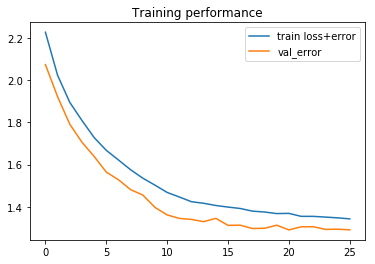

In [15]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

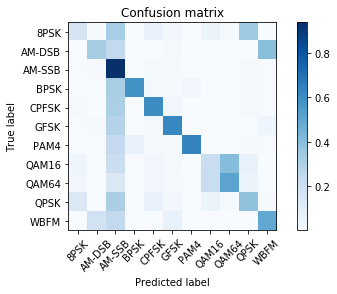

In [17]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.09789569990850869
Overall Accuracy:  0.0924613987284287
Overall Accuracy:  0.09424746743849494
Overall Accuracy:  0.10212919523637676
Overall Accuracy:  0.13108477666362808
Overall Accuracy:  0.2066820685978319
Overall Accuracy:  0.33437442586808747
Overall Accuracy:  0.4912023460410557
Overall Accuracy:  0.6014787430683919
Overall Accuracy:  0.6685413642960812
Overall Accuracy:  0.7018248175182482
Overall Accuracy:  0.7050163576881134
Overall Accuracy:  0.7081497797356828
Overall Accuracy:  0.7166064981949458
Overall Accuracy:  0.7186654643823264
Overall Accuracy:  0.724408014571949
Overall Accuracy:  0.7101213108817671
Overall Accuracy:  0.7263332718213693
Overall Accuracy:  0.711131221719457
Overall Accuracy:  0.717911791179118


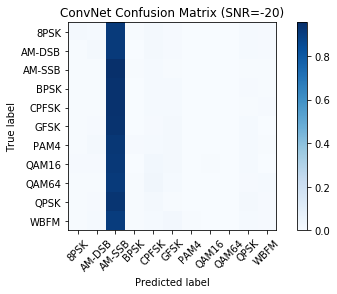

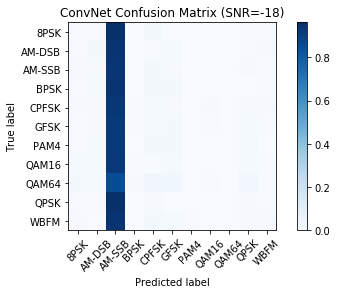

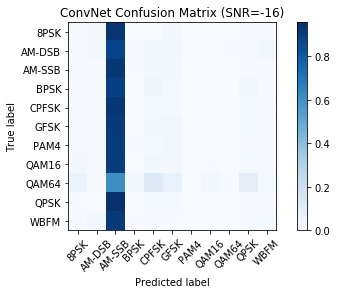

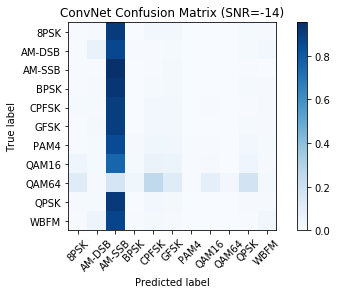

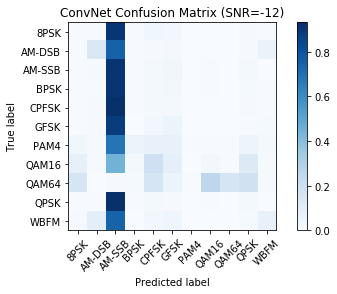

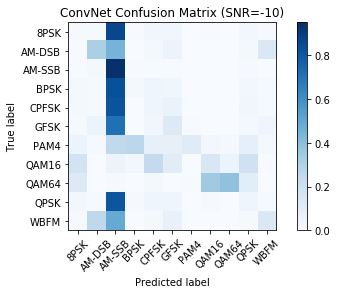

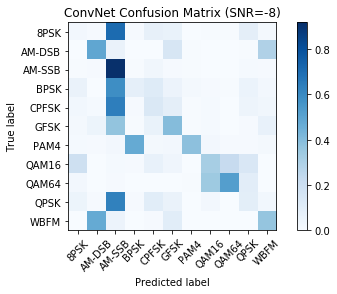

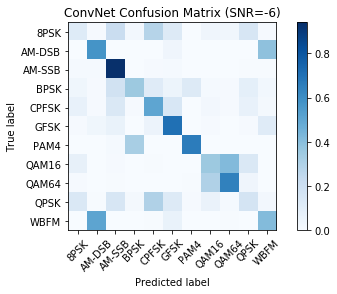

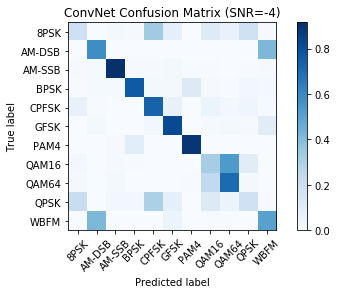

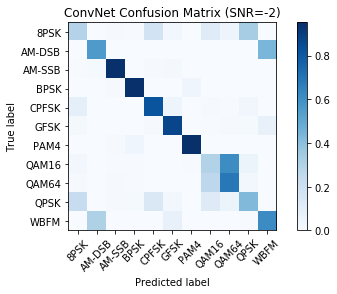

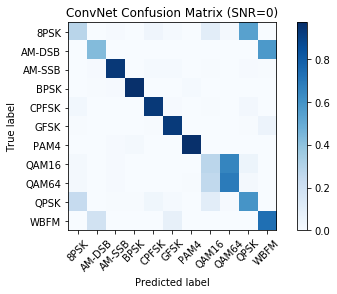

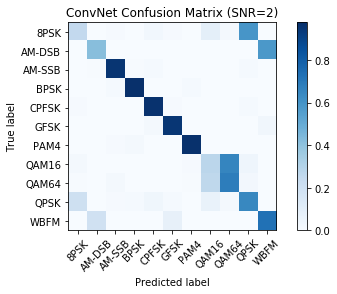

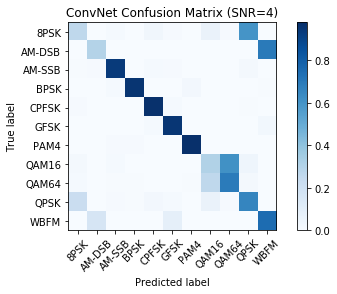

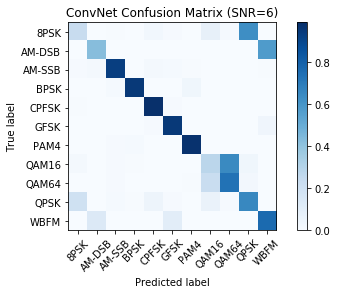

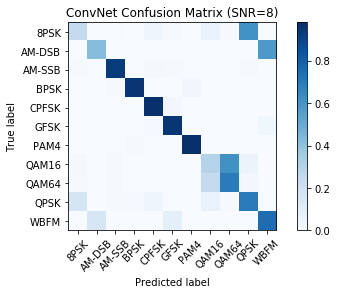

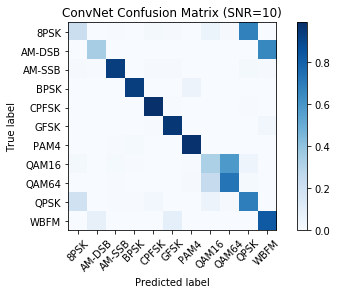

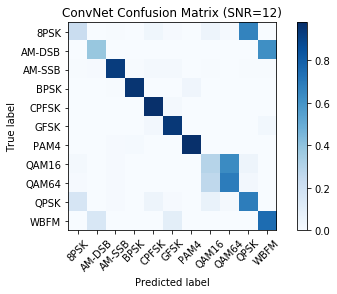

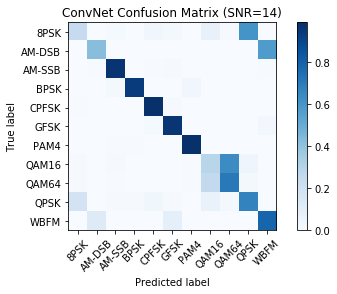

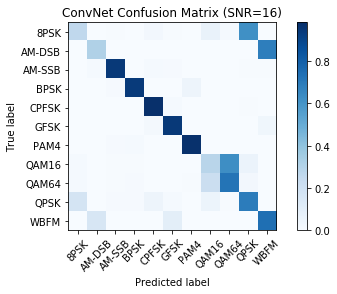

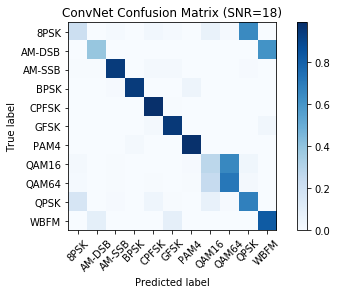

In [18]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [19]:
# Save results to a pickle file for plotting later
print (acc)
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )
fd.close()

{-20: 0.09789569990850869, -18: 0.0924613987284287, -16: 0.09424746743849494, -14: 0.10212919523637676, -12: 0.13108477666362808, -10: 0.2066820685978319, -8: 0.33437442586808747, -6: 0.4912023460410557, -4: 0.6014787430683919, -2: 0.6685413642960812, 0: 0.7018248175182482, 2: 0.7050163576881134, 4: 0.7081497797356828, 6: 0.7166064981949458, 8: 0.7186654643823264, 10: 0.724408014571949, 12: 0.7101213108817671, 14: 0.7263332718213693, 16: 0.711131221719457, 18: 0.717911791179118}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

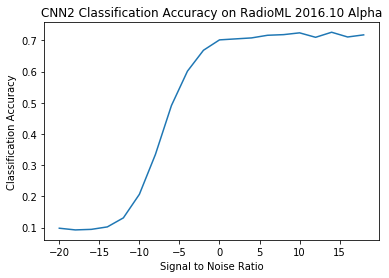

In [20]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

In [21]:
print("Done")

Done


In [22]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'all_results_cnn2_d0.5.dat'})
uploaded.SetContentFile('/content/results_cnn2_d0.5.dat')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'all_convmodrecnets_CNN2_0.5.wts.h5'})
uploaded.SetContentFile('/content/convmodrecnets_CNN2_0.5.wts.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1ufgA6R_Zkfm6Na7So-jBe3hRQjfyA_kk
Uploaded file with ID 1OwxLX57vjDuKwEYgioIVZKwwUs9-5nb0


In [0]:
#!kill -9 -1
